In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv

import random
import pickle

import sys
import time

In [2]:
from sklearn.svm            import SVR
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble       import BaggingRegressor
from sklearn.ensemble       import AdaBoostRegressor

from sklearn.utils          import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.multioutput    import MultiOutputRegressor

In [3]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
roll_nums = [5,15]#[3,5,7,10,12,15,18,20,22,25,28,30] # Generate an algorithm for predicting every few days
mom_nums  = [3,5,10,20,30]                     # Momentum has many good tracers
rsi_nums  = [10,15]                            # Good for some long term trends
band_nums = [5,10,15,20,25]                    # A few trace different areas well

In [5]:
inpFileList = ['aapl','acm' ,'awk' ,'amzn','awr' ,'ba'  ,'bac' ,'c'   ,'cat' ,'cop' ,'cvx' ,'dal' ,
               'dd'  ,'farm','fdp' ,'gnc' ,'hes' ,'ibm' ,'mas' ,'mcd' ,'mon' ,'msex','msft','nflx',
               'sbux','strl','tgt' ,'tsla','ups' ,'xom' ,'xpo' ,'vmc' ]

In [6]:
scaled_df = sf.get_scaled_data( inpFileList, roll_nums, mom_nums, rsi_nums, band_nums, close_percentage=False )

In [7]:
# Read in each stock, and perform reduction
#    Break into train, test sets
#    Store train, test sets in arrays
# For each regressor predicting a certain num of days...
#    Manually cross validate, testing and scoring each set

In [7]:
# Mix up the list
shuff_scaled_df = shuffle( scaled_df, random_state=0 )

n_elements = shuff_scaled_df.shape[0]

# Set the fraction of data we will train over
percent_train = 0.7

# Size of training set
n_train = int( percent_train * n_elements )

train_df = shuff_scaled_df[ :  n_train   ]
test_df  = shuff_scaled_df[    n_train : ]

In [21]:
train_x = train_df.dropna().drop( ['close','close_mean_5','close_mean_15'],axis=1 ).values
test_x  =  test_df.dropna().drop( ['close','close_mean_5','close_mean_15'],axis=1 ).values

train_y = train_df.dropna()['close_mean_5'].values
test_y  =  test_df.dropna()['close_mean_5'].values

In [10]:
# 0.259 - hls 10,10, alpha 1e-2

In [9]:
params = { 
            'hidden_layer_sizes' : [(10,10,)],
            'alpha'              : [1e-2]#,
#            'activation'         : ['relu','logistic','tanh']
         }

nn_reg = GridSearchCV( MLPRegressor( random_state=0 ), param_grid=params, cv=3 )

nn_reg.fit( train_x, train_y )
print nn_reg.best_score_
print nn_reg.best_params_

0.258796563032
{'alpha': 0.01, 'hidden_layer_sizes': (10, 10)}


In [22]:
nn_reg = MLPRegressor( alpha=1e-2, hidden_layer_sizes=(100,100,50,) )

nn_reg.fit( train_x, train_y )

MLPRegressor(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [13]:
# 0.231 mf 0.9, mss 50, md none

In [10]:
params = { 
            'n_estimators'      : [20],
            'min_samples_split' : [50],
            'max_features'      : [0.9],
         }

rf_reg = GridSearchCV( RandomForestRegressor( random_state=0 ), param_grid=params, cv=2 )
rf_reg.fit( train_x, train_y )
print rf_reg.best_score_
print rf_reg.best_params_

0.231123927394
{'max_features': 0.9, 'min_samples_split': 50, 'n_estimators': 20}


In [23]:
rf_reg = RandomForestRegressor( max_features=0.7, n_estimators=20, random_state=0 )

rf_reg.fit( train_x, train_y )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
# 0.049 kernel linear, c 1e-2, gamma 1e-4

In [11]:
params = {  
            'kernel':['linear'],
            'C' : [1e-1],
            'gamma': [1e-4]
         }

sv_reg = GridSearchCV( SVR(), param_grid=params, cv=2 )
sv_reg.fit( train_x, train_y )
print sv_reg.best_score_
print sv_reg.best_params_

0.0485166425997
{'kernel': 'linear', 'C': 0.1, 'gamma': 0.0001}


In [24]:
sv_reg = SVR( C=10, gamma=1e-3 )

sv_reg.fit( train_x, train_y )

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [17]:
# 

In [ ]:
params = { 
            'base_estimator' : [RandomForestRegressor( random_state=0 ),
                                MLPRegressor         ( random_state=0 )],
            'max_features'   : [1.0,0.9]
         }

ba_reg = GridSearchCV( BaggingRegressor( random_state=0 ), param_grid=params, cv=3 )
ba_reg.fit( train_x, train_y )
print ba_reg.best_score_
print ba_reg.best_params_

/home/sean/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/home/sean/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [26]:
ba_reg = BaggingRegressor( RandomForestRegressor( random_state=0, max_features=0.7, n_estimators=10), n_estimators=20 )

ba_reg.fit( train_x, train_y )

BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [19]:
# 

In [ ]:
params = { 
            'base_estimator' : [SVR( kernel='rbf', C=1, gamma=1e-2     )],
            'max_features'   : [1.0,0.8],
            'max_samples'    : [1.0,0.8]
         }

bs_reg = GridSearchCV( BaggingRegressor( random_state=0 ), param_grid=params, cv=3 )
bs_reg.fit( train_x, train_y )
print bs_reg.best_score_
print bs_reg.best_params_

In [21]:
# 

In [ ]:
params = { 
            'loss'           : ['exponential','square'],
            'n_estimators'   : [10]
            
         }

ad_reg = GridSearchCV( AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=5 ), random_state=0 ), 
                       param_grid=params, cv=3 )

ad_reg.fit( train_x, train_y )
print ad_reg.best_score_
print ad_reg.best_params_

In [27]:
ad_reg = AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=5 , random_state=0 ), n_estimators=10 )

ad_reg.fit( train_x, train_y )

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=5, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False),
         learning_rate=1.0, loss='linear', n_estimators=10,
         random_state=None)

In [28]:
nn_y = nn_reg.predict( test_x )
rf_y = rf_reg.predict( test_x )
ba_y = ba_reg.predict( test_x )
sv_y = sv_reg.predict( test_x )
#bs_y = sv_reg.predict( test_x )
ad_y = ad_reg.predict( test_x )

In [13]:
avg  = ( nn_y + sv_y + rf_y )/3.0

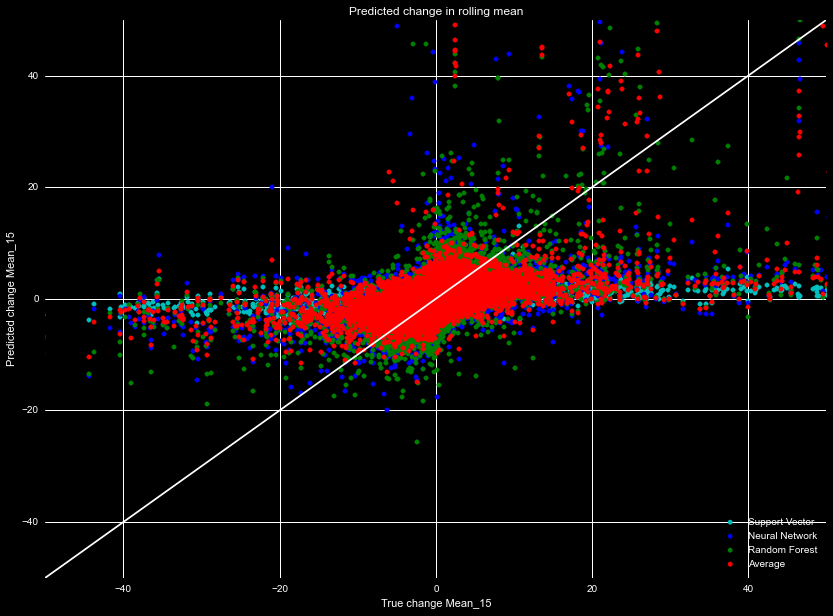

In [31]:
# Plot the data

plt.scatter( test_y,  sv_y, color='c', label='Support Vector' )
plt.scatter( test_y,  nn_y, color='b', label='Neural Network' )
#plt.scatter( test_y,  sv_y, color='w', label='Bagging SVR'    )
plt.scatter( test_y,  rf_y, color='g', label='Random Forest'  )
#plt.scatter( test_y,  ba_y, color='b', label='Bagging'        )
#plt.scatter( test_y,  ad_y, color='y', label='Adaboost'       )
plt.scatter( test_y,   avg, color='r', label='Average'        )

low =-50
hi  = 50

plt.plot( [low,hi], [low,hi], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(low,hi)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('True change Mean_15')
plt.ylabel('Predicted change Mean_15')
plt.title('Predicted change in rolling mean')
plt.show()

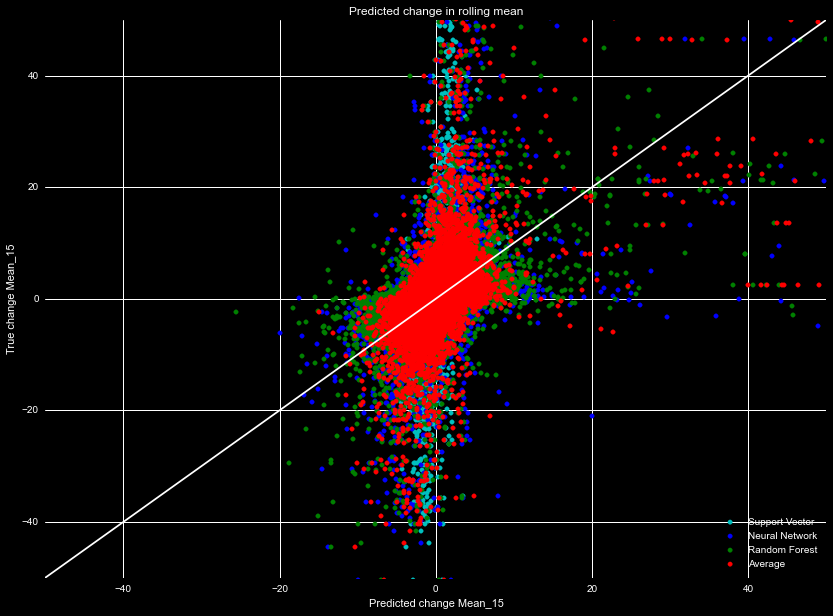

In [32]:
# Plot the data

plt.scatter( sv_y, test_y, color='c', label='Support Vector' )
plt.scatter( nn_y, test_y, color='b', label='Neural Network' )
plt.scatter( rf_y, test_y, color='g', label='Random Forest'  )
#plt.scatter( ba_y, test_y, color='b', label='Bagging'        )
#plt.scatter( ad_y, test_y, color='y', label='Adaboost'       )
plt.scatter(  avg, test_y, color='r', label='Average'        )

low =-50
hi  = 50

plt.plot( [low,hi], [low,hi], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(low,hi)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Predicted change Mean_15')
plt.ylabel('True change Mean_15')
plt.title('Predicted change in rolling mean')
plt.show()

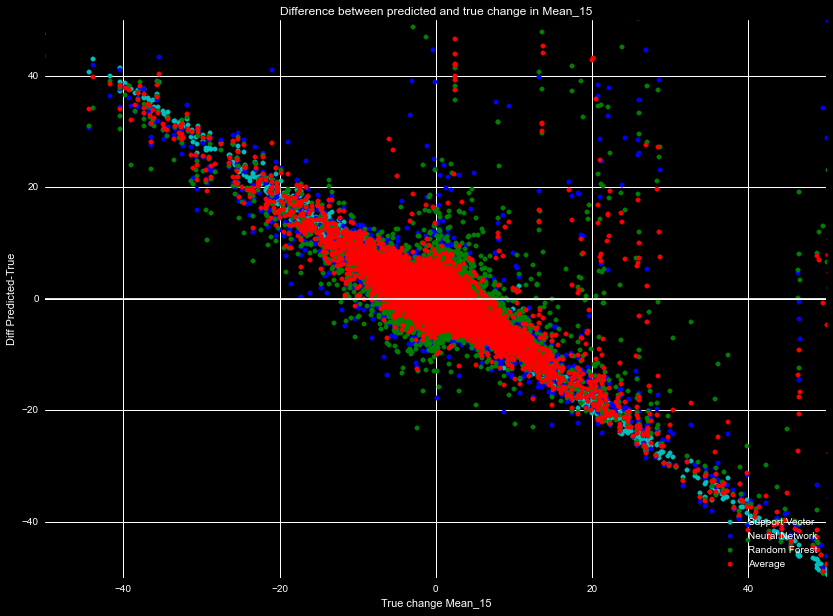

In [33]:
# Plot the data

plt.scatter( test_y,  sv_y-test_y, color='c', label='Support Vector' )
plt.scatter( test_y,  nn_y-test_y, color='b', label='Neural Network' )
plt.scatter( test_y,  rf_y-test_y, color='g', label='Random Forest'  )
#plt.scatter( test_y,  ba_y-test_y, color='b', label='Bagging'        )
#plt.scatter( test_y,  ad_y-test_y, color='y', label='Adaboost'       )
plt.scatter( test_y,   avg-test_y, color='r', label='Average'        )

low =-50
hi  = 50

plt.plot( [low,hi], [0,0], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(low,hi)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('True change Mean_15')
plt.ylabel('Diff Predicted-True')
plt.title('Difference between predicted and true change in Mean_15')
plt.show()

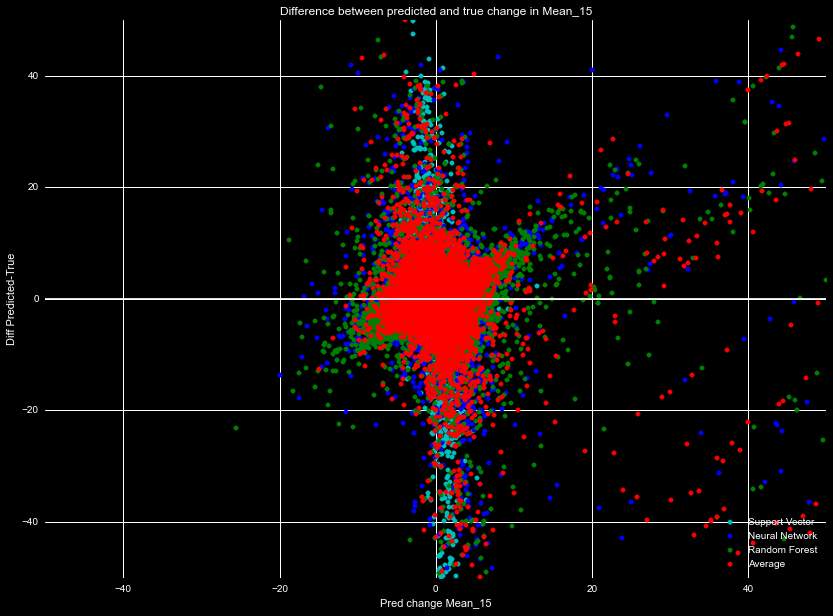

In [34]:
# Plot the data

plt.scatter( sv_y,  sv_y-test_y, color='c', label='Support Vector' )
plt.scatter( nn_y,  nn_y-test_y, color='b', label='Neural Network' )
plt.scatter( rf_y,  rf_y-test_y, color='g', label='Random Forest'  )
#plt.scatter( ba_y,  ba_y-test_y, color='b', label='Bagging'        )
#plt.scatter( ad_y,  ad_y-test_y, color='y', label='Adaboost'       )
plt.scatter(  avg,   avg-test_y, color='r', label='Average'        )

low =-50
hi  = 50

plt.plot( [low,hi], [0,0], color='w' )

plt.legend( loc=4 )
plt.xlim(low,hi)
plt.ylim(low,hi)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Pred change Mean_15')
plt.ylabel('Diff Predicted-True')
plt.title('Difference between predicted and true change in Mean_15')
plt.show()

In [29]:
print 'Support Vector MSE: %7.5f' % mean_squared_error( test_y, sv_y )
print 'Random Forest  MSE: %7.5f' % mean_squared_error( test_y, rf_y )
print 'Neural Network MSE: %7.5f' % mean_squared_error( test_y, nn_y )
print 'Bagging        MSE: %7.5f' % mean_squared_error( test_y, ba_y )
print 'Adaboost       MSE: %7.5f' % mean_squared_error( test_y, ad_y )
#print 'Averaged       MSE: %7.5f' % mean_squared_error( test_y, avg  )

Support Vector MSE: 33.48439
Random Forest  MSE: 27.43023
Neural Network MSE: 24.33563
Bagging        MSE: 25.45217
Adaboost       MSE: 27.94779


Mean_5
Support Vector MSE: 33.48439
Random Forest  MSE: 27.43023
Neural Network MSE: 24.33563
Bagging        MSE: 25.45217
Adaboost       MSE: 27.94779

Mean_15
Support Vector MSE: 81.79638
Random Forest  MSE: 63.86816
Neural Network MSE: 64.18347
Bagging        MSE: 62.87556
Adaboost       MSE: 64.31380

In [71]:
plot_frame = pd.DataFrame( {'true':target_values} )
plot_frame['random_forest' ] = rf_reg.predict( variable_values ) - plot_frame['true']
plot_frame['neural_network'] = nn_reg.predict( variable_values ) - plot_frame['true']
plot_frame['bagging'       ] = ba_reg.predict( variable_values ) - plot_frame['true']
plot_frame['average'       ] = (plot_frame['random_forest' ]+
                                plot_frame['bagging'       ]+
                                plot_frame['neural_network'])/3

In [72]:
ll   = 0.5
reg1 = 'random_forest'
reg2 = 'neural_network'
reg3 = 'bagging'
reg4 = 'average'

ax1 = plot_frame.plot(kind='scatter', x='true', y=reg1, color='g', alpha=0.3, label=reg1 )    
ax2 = plot_frame.plot(kind='scatter', x='true', y=reg2, color='r', alpha=0.3, label=reg2, ax=ax1)
ax3 = plot_frame.plot(kind='scatter', x='true', y=reg3, color='b', alpha=0.3, label=reg3, ax=ax1)
ax4 = plot_frame.plot(kind='scatter', x='true', y=reg4, color='k', alpha=0.3, label=reg4, ax=ax1)

#ax1.plot( [-ll,ll], [-ll,ll], color='k' )
ax1.set_ybound( [-ll,ll] )
ax1.set_xlabel( 'True Value' )
ax1.set_ylabel( 'predicted-true' )
ax1.legend( loc=2 )

plt.show()